<a href="https://colab.research.google.com/github/Abdullah-Al-Muaddi/Sheep-Classification-Model/blob/main/Sheep_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

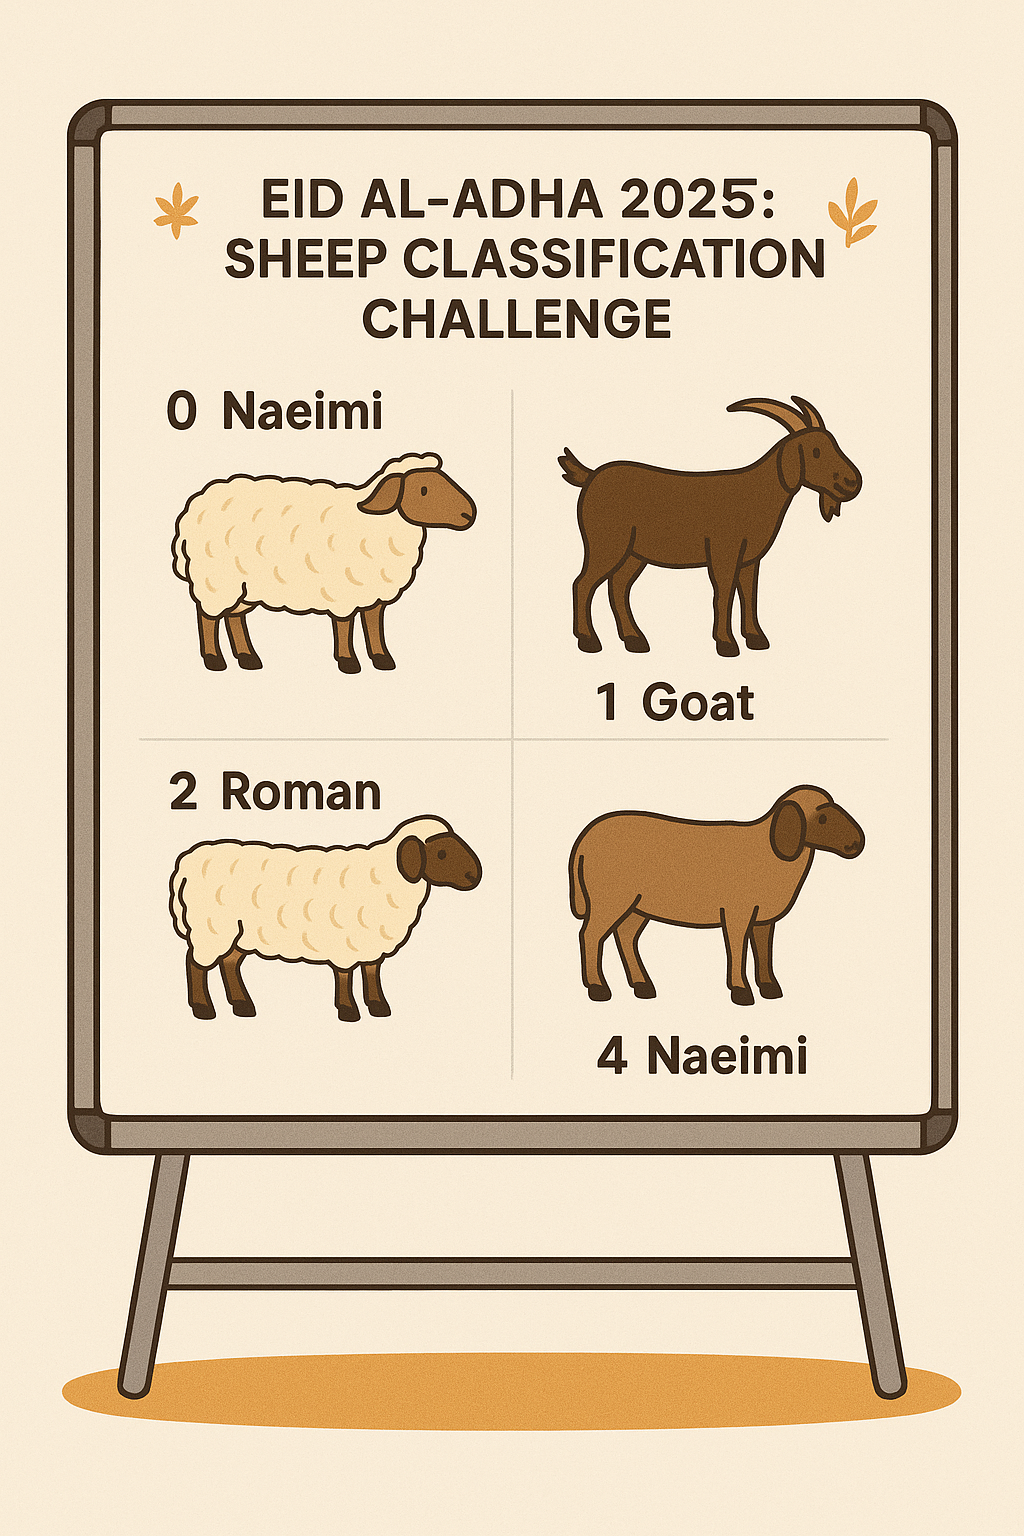

# 🐑 **AI Model for Classifying Sheep Types** 🐑

This AI model has been created for a Kaggle competition: 🏆 [Eid Al-Adha 2025: Sheep Classification Challenge](https://www.kaggle.com/competitions/sheep-classification-challenge-2025)

> Before going into details, I'd like to mention these two Kaggle courses that helped me jump into my first CNN Kaggle competition: (4 hours each)
*   📚 [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning)
*   📚 [Computer Vision](https://www.kaggle.com/learn/computer-vision)

Let's dive into the code! 🚀

## Upload or Access the Dataset

Before we can begin analyzing and modeling the data, we need to make it accessible in this environment. You have a couple of ways to get the dataset:

1.  **Using the Kaggle API:** If you have your Kaggle API credentials set up, you can use the Kaggle API to directly download the data. Simply run the code cell below.
2.  **Manual Download:**  you can manually download the dataset files from the Kaggle competition page, you can skip the Kaggle API code cells that follow this explanation.

    You can download the data from the competition's data page: [Sheep Classification Challenge 2025 Data](https://www.kaggle.com/competitions/sheep-classification-challenge-2025/data)




In [ ]:
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
sheep_classification_challenge_2025_path = kagglehub.competition_download('sheep-classification-challenge-2025')

print('Data source import complete.')


100%|██████████| 34.7M/34.7M [00:01<00:00, 20.8MB/s]

Extracting files...


Data source import complete.


## Importing necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import F1Score
from tensorflow.keras import layers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import warnings
import random
warnings.filterwarnings("ignore")

# Set up variables

In [ ]:
# Constants variables
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 35
SEED = 8
NUM_CLASSES= 7
TTA_STEPS=5

In [ ]:
# Ensure reproducibility by setting a seed
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
KAGGLE_INPUT_ROOT = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images'
KAGGLE_INPUT_ROOT = sheep_classification_challenge_2025_path + '/Sheep Classification Images' #updated it afterward
TRAIN_DIR = os.path.join(KAGGLE_INPUT_ROOT, "train")
TEST_DIR = os.path.join(KAGGLE_INPUT_ROOT, "test")
TRAIN_CSV_PATH = os.path.join(KAGGLE_INPUT_ROOT, "train_labels.csv")

In [ ]:
train_csv = pd.read_csv(TRAIN_CSV_PATH)
train_csv.head()

filename   label
0  39d30b68.jpg  Naeimi
1  4a9853bd.jpg    Goat
2  d88facaa.jpg   Roman
3  a3f4f4af.jpg   Roman
4  16b31730.jpg  Naeimi

## Visualizing the data

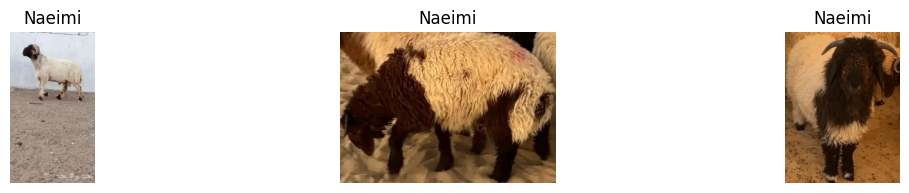

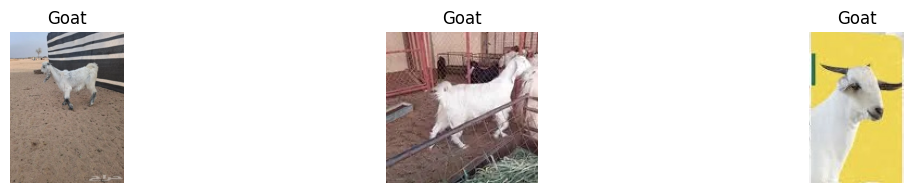

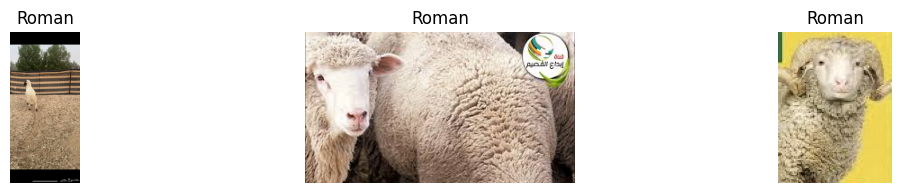

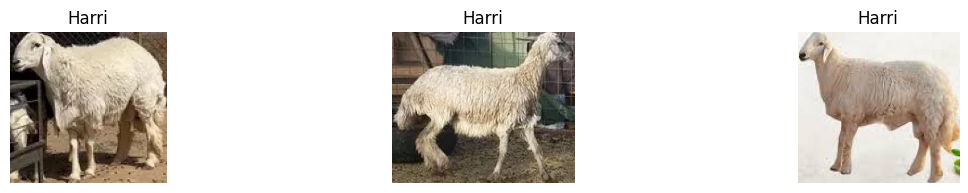

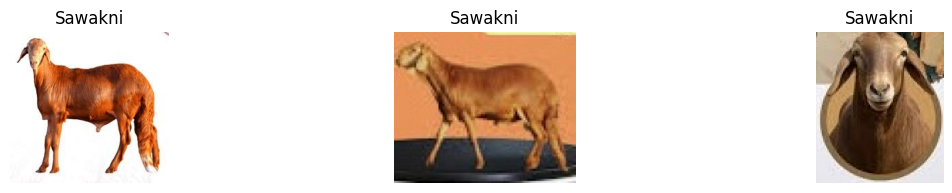

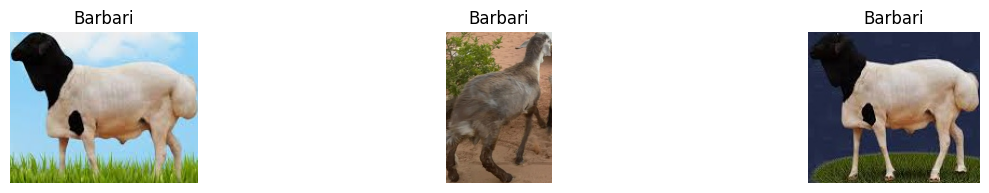

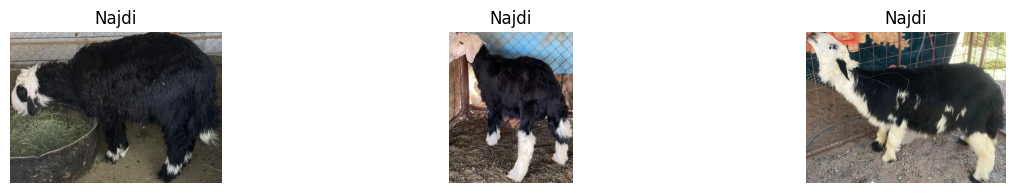

In [ ]:
breeds = train_csv["label"].unique()
breeds_num = len(breeds)
for breed in breeds:
  breed_pic_address=train_csv[train_csv["label"]==breed]["filename"]
  breed_pics = random.sample(list(TRAIN_DIR + "/" + breed_pic_address), 3)
  plt.figure(figsize=(12, 12))
  for i in range(3):
    plt.subplot(breeds_num, 3, i + 1)
    img = Image.open(breed_pics[i])
    plt.imshow(img)
    plt.title(breed)
    plt.axis('off')
  plt.tight_layout()
  plt.show()



In [ ]:
print(f"The classes distribution: \n { train_csv['label'].value_counts()}")

The classes distribution: 
 label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


In [ ]:
# Split data using the original string labels for stratification
train_df, val_df = train_test_split(
    train_csv,
    test_size=0.20,
    stratify=train_csv.label,
    random_state=SEED
)
print(f"train datafram shape = {train_df.shape} , validation  datafram shape = {val_df.shape}")

train datafram shape = (545, 2) , validation  datafram shape = (137, 2)


## Create augmented data

We have a very small amount of data, which can be a challenge as it increases the risk of overfitting. To fix that i'm going to use **data augmentation** ,
and `ImageDataGenerator()` method will help us do that.

In [ ]:
# --- Setup ImageDataGenerators ---
train_datagen = ImageDataGenerator( #try to increases the values and theck if the F1 score increased or not
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator()


print("\n--- Creating Data Generators ---")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)



--- Creating Data Generators ---
Found 545 validated image filenames belonging to 7 classes.


In [ ]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, #shuffling it or not, son't make won't make a different.
    seed=SEED
)

Found 137 validated image filenames belonging to 7 classes.


In [ ]:
# Verify the class distribution in both sets
print("\nTraining set class distribution:")
print(train_df['label'].value_counts(normalize=True))
print("\nValidation set class distribution:")
print(val_df['label'].value_counts(normalize=True))


Training set class distribution:
label
Naeimi     0.374312
Goat       0.155963
Sawakni    0.117431
Roman      0.104587
Najdi      0.104587
Harri      0.091743
Barbari    0.051376
Name: proportion, dtype: float64

Validation set class distribution:
label
Naeimi     0.372263
Goat       0.160584
Sawakni    0.116788
Roman      0.109489
Najdi      0.102190
Harri      0.087591
Barbari    0.051095
Name: proportion, dtype: float64


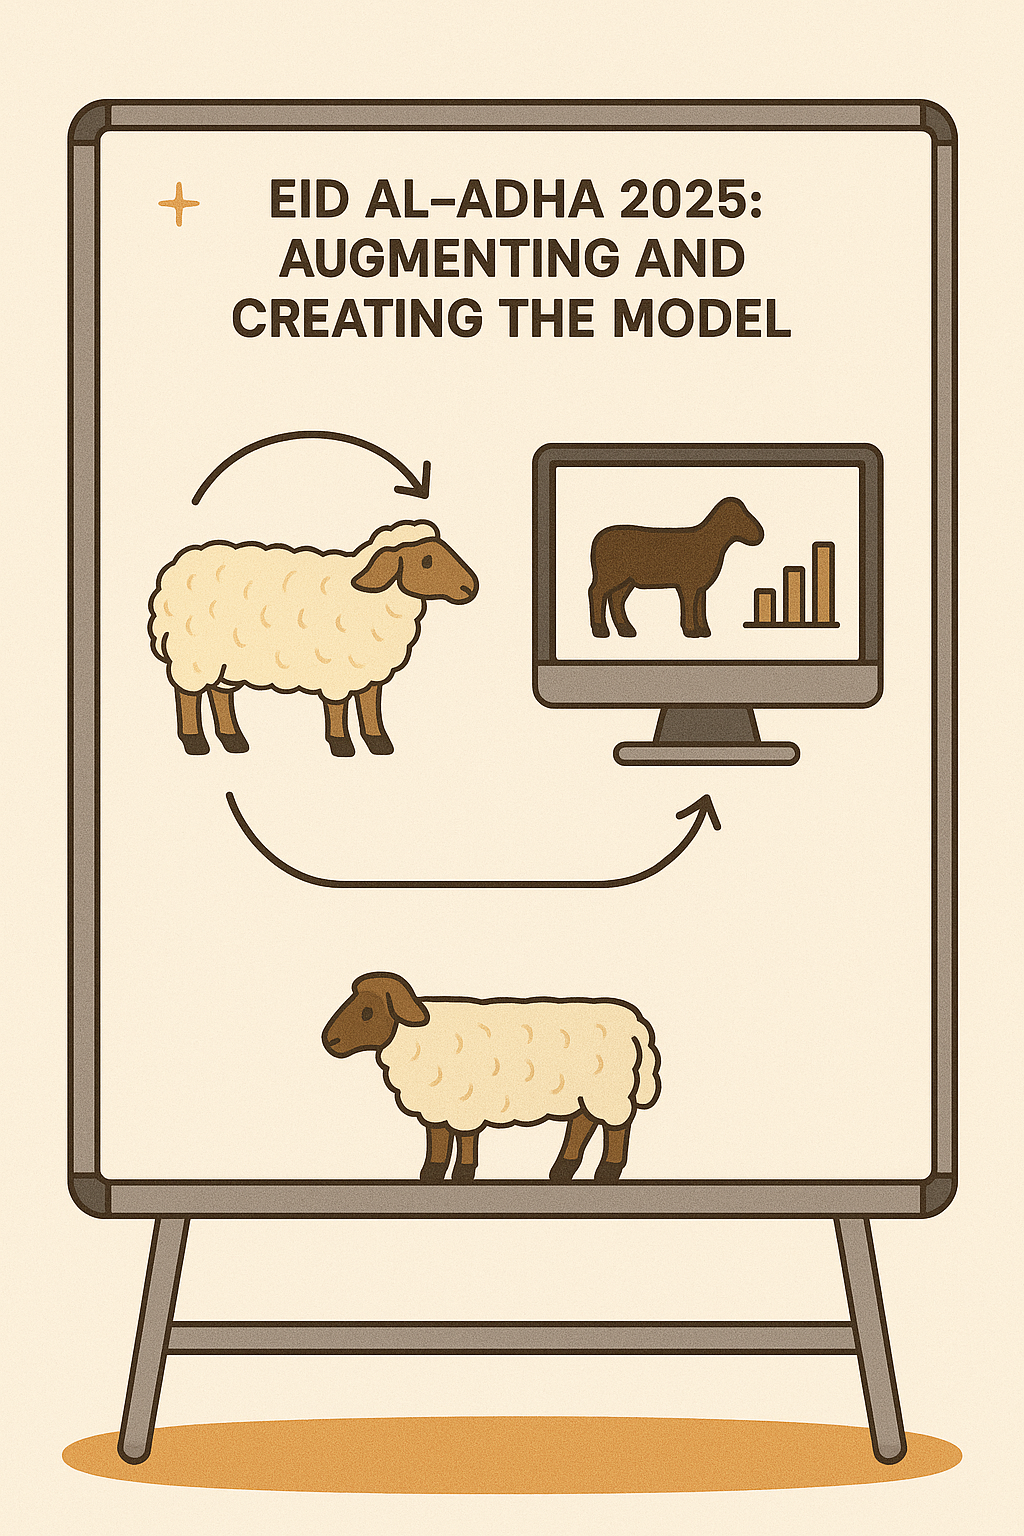

In [ ]:
# Model definition
def create_model():
    base_model = applications.ConvNeXtXLarge( # try to use different models like "convnextv2_base.fcmae_ft_in22k_in1k" i heard it appear to do great
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        # pooling='avg'
    )

    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3), # To decrease the risk of overfitting
        layers.Dense(NUM_CLASSES, activation='softmax')   # he final Dense output layer
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score(average='macro')]
   )

    return model

callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True,monitor='val_f1_score',mode='max'),
    ModelCheckpoint("best_model.h5", monitor='val_f1_score',save_best_only=True,verbose=1,mode='max'),
    # ReduceLROnPlateau(factor=0.1, patience=3,monitor='val_f1_score', min_delta=0.01)
]





In [ ]:
model = create_model()
model.summary()

1393257616/1393257616 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_xlarge (Functional)    │ (None, 7, 7, 2048)     │   348,147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        14,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,162,311 (1.30 GB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 348,147,968 (1.30 GB)

In [ ]:
# Compute class weights from the training dataframe
class_labels = train_csv['label'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(class_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(encoded_labels),
    y=encoded_labels
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
# Initial training
print("\n--- Starting Initial Model Training ---")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Fine-tuning
# print("\n--- Starting Fine-tuning ---")
# base_model = model.layers[0]  # Access base_model from Sequential
# base_model.trainable = True
# for layer in base_model.layers[:-20]:  # Freeze all but top 20 layers
#     layer.trainable = False

# # Recompile with a new low learning rate
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-5),
#     loss='categorical_crossentropy',
#     metrics=['accuracy',F1Score(average='macro')]
# )

# # Continue training
# history_fine = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=EPOCHS,
#     initial_epoch=history.epoch[-1],
#     callbacks=callbacks,
#     class_weight=class_weight_dict
# )


--- Starting Initial Model Training ---
Epoch 1/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2958 - f1_score: 0.2707 - loss: 1.8420
Epoch 1: val_f1_score improved from -inf to 0.75867, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.3028 - f1_score: 0.2772 - loss: 1.8291 - val_accuracy: 0.7810 - val_f1_score: 0.7587 - val_loss: 0.9327
Epoch 2/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7131 - f1_score: 0.6657 - loss: 0.9453
Epoch 2: val_f1_score improved from 0.75867 to 0.85496, saving model to best_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.7142 - f1_score: 0.6671 - loss: 0.9421 - val_accuracy: 0.8832 - val_f1_score: 0.8550 - val_loss: 0.5506
Epoch 3/35
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8329 - f1_score: 0.7870 - loss: 0.6217
Epoch 3: val_f1_score did not improve from 0.85496
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8314 - f1_score: 0.7871 - loss: 0.6220 - val_accuracy: 0.8759 - val_f1_score: 0.8515 - val_loss: 0.4833
Epoch 4/35
 9/18 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8098 - f1_score: 0.7739 - loss: 0.6187   

KeyboardInterrupt: 

In [ ]:
model.load_weights("best_model.h5")  # ensure best weights are loaded

## Plotting the results

In [ ]:
# Combine histories for plotting
# combined_history = {}
# for key in history.history.keys():
#     combined_history[key] = history.history[key] + history_fine.history[key]

history_frame = pd.DataFrame(history.history)
#Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_frame['loss'], label='Loss')
plt.plot(history_frame['val_loss'], label='Val_Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_frame['f1_score'], label='F1Score')
plt.plot(history_frame['val_f1_score'], label='Val_F1Score')
plt.title('F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Evaluate the model on the validation set after training
print("\n--- Evaluating Final Model Performance ---")
val_loss, val_accuracy, val_f1_score = model.evaluate(val_generator)
print(f"VL: {val_loss:.4f} | VAcc: {val_accuracy:.4f} | VF1 (macro): {val_f1_score:.4f}")

## Uses the test dataset to predict the breeds

In [ ]:
test_files = sorted(os.listdir(TEST_DIR))
test_df = pd.DataFrame({'filename': test_files})

# Create TTA generator
tta_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_generator = tta_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='filename',
    y_col=None,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=SEED
)

# Verify test generator found images
print(f"\nFound {test_generator.samples} test images")

In [ ]:
# Make predictions with TTA
if test_generator.samples > 0:
    # Initialize array to store predictions
    all_predictions = []

    print(f"\nPerforming Test Time Augmentation with {TTA_STEPS} steps...")
    for i in range(TTA_STEPS):
        print(f"TTA step {i+1}/{TTA_STEPS}")
        test_generator.reset()  #reset generator to avoid randomness between epochs
        preds = model.predict(test_generator)
        all_predictions.append(preds)

    # average predictions across all TTA steps
    avg_predictions = np.mean(all_predictions, axis=0)
    predicted_classes = tf.argmax(avg_predictions, axis=1)
    class_names = list(train_generator.class_indices.keys())
    predicted_labels = [class_names[i] for i in predicted_classes]

    # Prepare submission
    submission = pd.DataFrame({
        'filename': test_files,
        'label': predicted_labels
    })
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file with TTA created successfully!")
else:
    print("Error: No test images found. Check your TEST_DIR path.")

## At the end, this is the code I wrote and the public F1 score I achieved.

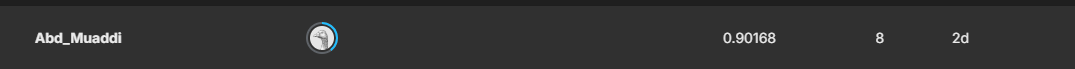

## If I were to start over, here's what I would do:

---

*   Evaluate the incorrectly predicted outputs to identify common patterns and errors, and then address them in the model.
*   Apply a wider range of post-processing rules.

